## **Задание по итогам курса "Основы работы c PyTorch":**

- (упрощенное/для тех, у кого нет вебкамеры)
    1. Нужно написать приложение, которое будет получать на вход *изображение*.
    2. В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
    3. На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.

- (более сложное)
    1. Нужно написать приложение, которое будет считывать и выводить кадры с *веб-камеры*.
    2. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре.
    3. Человек показывает жесты руками, а алгоритм должен считать их и классифицировать. 
____________________
- Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.
- Как работать с веб-камерой на google colab https://stackoverflow.com/questions/54389727/opening-web-camera-in-google-colab


У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/bVsUadhax5Uosg

или использовать более простые датасеты:

https://www.kaggle.com/gti-upm/leapgestrecog

https://www.kaggle.com/datamunge/sign-language-mnist

https://www.kaggle.com/roobansappani/hand-gesture-recognition 

или более интересный https://lttm.dei.unipd.it/downloads/gesture/ 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# загрузим данные с kaggle

! pip install kaggle
! mkdir ~/.kaggle
! cp '/content/drive/MyDrive/Colab Notebooks/PyTorch/kaggle.json' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download <name-of-competition>
! kaggle datasets download gti-upm/leapgestrecog
! unzip leapgestrecog.zip

In [ ]:
# импортируем библиотеки

import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import tensorflow as tf
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import re
import cv2
from sklearn.model_selection import train_test_split
from torchvision.io import read_image
torch.cuda.empty_cache()
from torchsummary import summary
from torchvision import models
!pip install facenet_pytorch
!pip install mediapipe
from facenet_pytorch import MTCNN
from google.colab.patches import cv2_imshow
import mediapipe as mp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 7.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.9 MB 1.3 MB/s 


In [ ]:
# функцию для просмотра случайных картинок из даталоудера

def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

## **HAND GESTURE CLASSIFIER**

### **DATA PREPROCESSING**

In [ ]:
DATA_ROOT = '/content/leapgestrecog'

In [ ]:
# запишем названия классов

classes = os.listdir(DATA_ROOT + '/leapGestRecog/00/')
print(f'Classes: {classes}')

Classes: ['08_palm_moved', '05_thumb', '04_fist_moved', '06_index', '03_fist', '01_palm', '10_down', '02_l', '09_c', '07_ok']


In [ ]:
%%time
# сформируем список путей к файлам и название класса

gestures_list = []

for root, dirs, files in os.walk(DATA_ROOT):     
    for name in files:        
        f = os.path.join(root, name)
        for class_name in classes:
            if class_name in f:
                gestures_list.append([f, int(re.findall(r'[0-9]', class_name)[1])])

CPU times: user 105 ms, sys: 9.1 ms, total: 114 ms
Wall time: 117 ms


In [ ]:
# количество примеров
print(f'Number of samples: {len(gestures_list)}')

Number of samples: 20000


In [ ]:
# создадим датафрейм с путями и метками
df_paths = pd.DataFrame(gestures_list, columns=(['img_path', 'digit_class']))
df_paths.tail()

img_path  digit_class
19995  /content/leapgestrecog/leapGestRecog/00/07_ok/...            7
19996  /content/leapgestrecog/leapGestRecog/00/07_ok/...            7
19997  /content/leapgestrecog/leapGestRecog/00/07_ok/...            7
19998  /content/leapgestrecog/leapGestRecog/00/07_ok/...            7
19999  /content/leapgestrecog/leapGestRecog/00/07_ok/...            7

Image size: (240, 640)


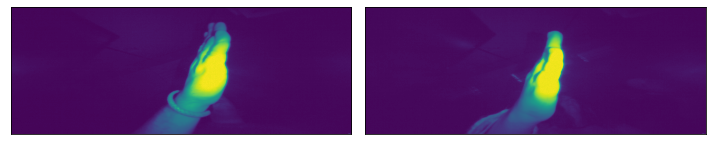

In [ ]:
# визуализируем примеры

img_1 = plt.imread(df_paths.iloc[0][0])
img_2 = plt.imread(df_paths.iloc[10000][0])
print(f'Image size: {img_1.shape}')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_1)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(img_2)
ax[1].set_xticks([])
ax[1].set_yticks([])

fig.tight_layout()
    
plt.show()

In [ ]:
len(df_paths.index)

20000

In [ ]:
# зададим параметры предпроцессинга

crop_height = 240
crop_width = 300
resize_img = 128
num_output_channels = 1

train_tfms = tt.Compose([tt.ToPILImage(),
                         tt.CenterCrop((crop_height, crop_width)),
                         tt.Resize((resize_img, resize_img)),
                         tt.Grayscale(num_output_channels=num_output_channels),
                        #  tt.RandomPerspective(distortion_scale=0.6, p=1.0),
                        #  tt.GaussianBlur(kernel_size=(5, 9)),
                         tt.RandomHorizontalFlip(),           
                         tt.RandomRotation(30),
                         tt.ToTensor()
                         ])                     

test_tfms = tt.Compose([tt.ToPILImage(),
                        tt.CenterCrop((crop_height, crop_width)),
                        tt.Resize((resize_img, resize_img)),
                        tt.Grayscale(num_output_channels=num_output_channels),
                        tt.ToTensor()])

In [ ]:
# создадим класс кастомного датасета

class SelfDrivingDataset(Dataset):
    
    def __init__(self, data, preprocessing=None):
        
        self.data = data        
        self.image_arr = self.data.iloc[:, 0]
        self.label_arr = self.data.iloc[:, 1]
        self.data_len = len(self.data.index)        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        
        img = read_image(self.image_arr[index])
        
        if self.preprocessing:
            img = img / 255.0
            img = self.preprocessing(img)
        else:
            # нормализуем изображение в значениях [0, 1]
            img = torch.as_tensor(img) / 255.0
        
        label = self.label_arr[index]
            
        return (img, label)

    
    def __len__(self):
        return self.data_len

torch.Size([1, 128, 128]), label: 8
torch.Size([1, 128, 128]), label: 1


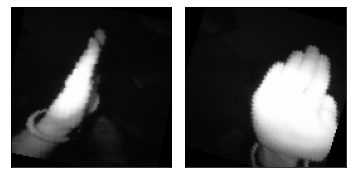

In [ ]:
# проверим работу класса

dataset = SelfDrivingDataset(df_paths, train_tfms)
img_1, label_1 = dataset[1]
img_2, label_2 = dataset[19000]
print(f'{img_1.shape}, label: {label_1}')
print(f'{img_2.shape}, label: {label_2}')

fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(tf.squeeze(img_1), cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(tf.squeeze(img_2), cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])

fig.tight_layout()
    
plt.show()

In [ ]:
# разделим данные на тренировочную выборку и тестовую
X_train, X_test = train_test_split(df_paths, test_size=0.3, shuffle=True)

# упорядочим индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# обернем каждую выборку в кастомный датасет
train_data = SelfDrivingDataset(X_train, train_tfms)
test_data = SelfDrivingDataset(X_test, test_tfms)

In [ ]:
# загрузим данные
batch_size = 16

train_data_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

test_data_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

print(f'Length Train: {len(train_data_loader)}')
print(f'Length Test: {len(test_data_loader)}')

Length Train: 875
Length Test: 375


torch.Size([1, 128, 128])
tensor(4)


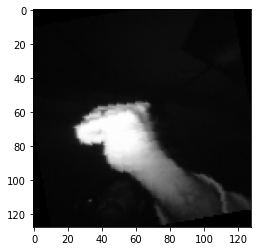

In [ ]:
# проверим работу даталоудера

for img, label in train_data_loader:
    print(img[1].shape)
    print(label[1])
    plt.imshow(img[1].permute(1, 2, 0)[:,:,0], cmap='gray')
    break

torch.Size([1, 128, 128])


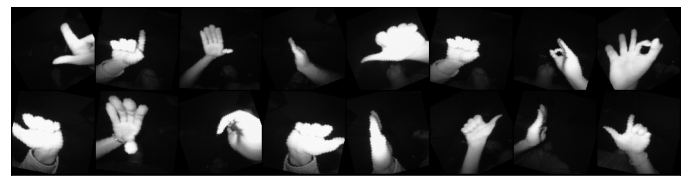

In [ ]:
# посмотрим на большее количество примеров
show_batch(train_data_loader)

In [ ]:
# проверим устройство
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### **MODEL DESCRIPTION**

In [ ]:
# опишем модель для распознавания жестов

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class GestureNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)

        self.conv7 = conv_block(512, 1024)
        self.conv8 = conv_block(1024, 1024, pool=True)
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))
        self.drop4 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(8), 
                                        nn.Flatten(),
                                        nn.Linear(1024, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)

        out = self.conv7(out)
        out = self.conv8(out)
        out = self.res4(out) + out
        out = self.drop4(out)
        
        out = self.classifier(out)
        return out

In [ ]:
# инициализируем модель
model = GestureNet(1, len(classes)).to(device)

In [ ]:
# посмотрим на параметры модели
print(model)
print("Parameters full train:", sum([param.nelement() for param in model.parameters()]))

GestureNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

### **MODEL TRAINING**

In [ ]:
# установим дополнительные параметры

num_epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# обучим модель

model.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 500 == 0:    # печатаем каждые 500 mini-batches
            model.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(test_data_loader):
            
                test_outputs = model(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
       
        model.train()
        
print('Training is finished!')


# Epoch [1/9]. Step [1/875]. Loss: 0.635. Acc: 0.062. Test acc: 0.101
# Epoch [1/9]. Step [501/875]. Loss: 0.153. Acc: 0.266. Test acc: 0.287
# Epoch [2/9]. Step [1/875]. Loss: 0.073. Acc: 0.625. Test acc: 0.806
# Epoch [2/9]. Step [501/875]. Loss: 0.047. Acc: 0.771. Test acc: 0.596
# Epoch [3/9]. Step [1/875]. Loss: 0.024. Acc: 0.875. Test acc: 0.750
# Epoch [3/9]. Step [501/875]. Loss: 0.029. Acc: 0.868. Test acc: 0.901
# Epoch [4/9]. Step [1/875]. Loss: 0.020. Acc: 0.938. Test acc: 0.818
# Epoch [4/9]. Step [501/875]. Loss: 0.022. Acc: 0.900. Test acc: 0.928
# Epoch [5/9]. Step [1/875]. Loss: 0.001. Acc: 1.000. Test acc: 0.845
# Epoch [5/9]. Step [501/875]. Loss: 0.023. Acc: 0.905. Test acc: 0.926
# Epoch [6/9]. Step [1/875]. Loss: 0.007. Acc: 0.938. Test acc: 0.897
# Epoch [6/9]. Step [501/875]. Loss: 0.017. Acc: 0.931. Test acc: 0.870
# Epoch [7/9]. Step [1/875]. Loss: 0.049. Acc: 0.812. Test acc: 0.847
# Epoch [7/9]. Step [501/875]. Loss: 0.014. Acc: 0.940. Test acc: 0.856
# Epoch [8/9]. Step [1/875]. Loss: 0.001. Acc: 1.000. Test acc: 0.953
# Epoch [8/9]. Step [501/875]. Loss: 0.012. Acc: 0.949. Test acc: 0.896
# Epoch [9/9]. Step [1/875]. Loss: 0.004. Acc: 1.000. Test acc: 0.860
# Epoch [9/9]. Step [501/875]. Loss: 0.011. Acc: 0.953. Test acc: 0.864
# Training is finished!

Epoch [1/5]. Step [1/875]. Loss: 0.258. Acc: 0.250. Test acc: 0.099
Epoch [1/5]. Step [501/875]. Loss: 0.082. Acc: 0.632. Test acc: 0.910
Epoch [2/5]. Step [1/875]. Loss: 0.027. Acc: 0.875. Test acc: 0.910
Epoch [2/5]. Step [501/875]. Loss: 0.022. Acc: 0.897. Test acc: 0.952
Epoch [3/5]. Step [1/875]. Loss: 0.011. Acc: 0.938. Test acc: 0.982
Epoch [3/5]. Step [501/875]. Loss: 0.013. Acc: 0.938. Test acc: 0.978
Epoch [4/5]. Step [1/875]. Loss: 0.000. Acc: 1.000. Test acc: 0.985
Epoch [4/5]. Step [501/875]. Loss: 0.015. Acc: 0.940. Test acc: 0.962
Epoch [5/5]. Step [1/875]. Loss: 0.013. Acc: 0.875. Test acc: 0.988
Epoch [5/5]. Step [501/875]. Loss: 0.015. Acc: 0.947. Test acc: 0.973
Training is finished!


In [ ]:
# сохраним модель
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/PyTorch/gestures_detection_model_V2.pth')

In [ ]:
saved_model = torch.load('/content/drive/MyDrive/Colab Notebooks/PyTorch/gestures_detection_model_V2.pth')
saved_model.eval()

GestureNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

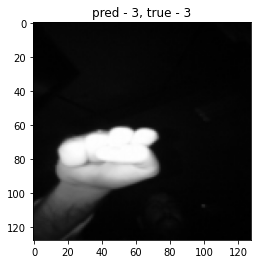

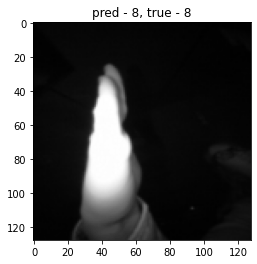

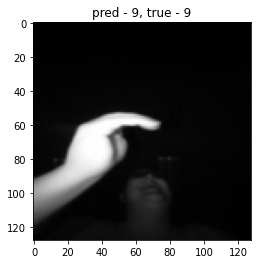

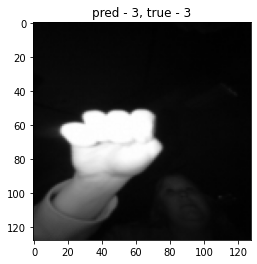

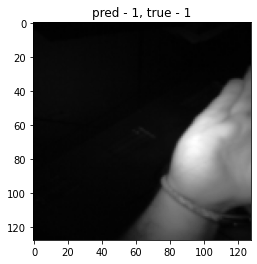

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_data_loader, 2):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = saved_model(images)
        plt.title(f'pred - {outputs[0].argmax()}, true - {labels[0]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>5:
            break

Результат предсказания довольно неплохой. На 9 эпохах модель явно переобучилась. Можно уменьшить количество эпох.

Попробуем взять готовую предобученную модель для сравнения результатов.

### **MOBILENETV3 MODEL**

In [ ]:
# зададим параметры предпроцессинга

num_output_channels = 3

train_tfms = tt.Compose([tt.ToPILImage(),
                         tt.CenterCrop((crop_height, crop_width)),
                         tt.Resize((resize_img, resize_img)),
                         tt.Grayscale(num_output_channels=num_output_channels),
                        #  tt.RandomPerspective(distortion_scale=0.6, p=1.0),
                        #  tt.GaussianBlur(kernel_size=(5, 9)),
                         tt.RandomHorizontalFlip(),           
                         tt.RandomRotation(30),
                         tt.ToTensor()
                         ])                     

test_tfms = tt.Compose([tt.ToPILImage(),
                        tt.CenterCrop((crop_height, crop_width)),
                        tt.Resize((resize_img, resize_img)),
                        tt.Grayscale(num_output_channels=num_output_channels),
                        tt.ToTensor()])

In [ ]:
# разделим данные на тренировочную выборку и тестовую
X_train, X_test = train_test_split(df_paths, test_size=0.3, shuffle=True)

# упорядочим индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# обернем каждую выборку в кастомный датасет
train_data = SelfDrivingDataset(X_train, train_tfms)
test_data = SelfDrivingDataset(X_test, test_tfms)

In [ ]:
# загрузим данные
batch_size = 32

train_data_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

test_data_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

print(f'Length Train: {len(train_data_loader)}')
print(f'Length Test: {len(test_data_loader)}')

Length Train: 437
Length Test: 188


torch.Size([3, 128, 128])
tensor(0)


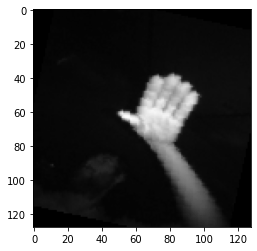

In [ ]:
# проверим работу даталоудера

for img, label in train_data_loader:
    print(img[1].shape)
    print(label[1])
    plt.imshow(img[1].permute(1, 2, 0)[:,:,0], cmap='gray')
    break

In [ ]:
# загрузим предобученную модель
resnet152 = models.resnet152(pretrained=True)
print(resnet152)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# заморозим преобученную модель
for param in list(resnet152.parameters())[:]:
    param.requires_grad = False

In [ ]:
# заменим последний слой на свой, на 10 выходов
resnet152.fc = nn.Linear(2048, 10)
summary(resnet152.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# переместим модель и данные на целевое устройство
resnet152 = resnet152.to(device)

In [ ]:
# создадим список параметров для адаптации
params_to_update = []
for name, param in resnet152.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# обучим модель
num_epochs = 5
resnet152.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet152(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 500 == 0:    # печатаем каждые 500 mini-batches
            resnet152.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(test_data_loader):
            
                test_outputs = resnet152(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
       
        resnet152.train()
        
print('Training is finished!')


# Epoch [1/9]. Step [1/437]. Loss: 0.073. Acc: 0.094. Test acc: 0.096
# Epoch [2/9]. Step [1/437]. Loss: 0.006. Acc: 0.969. Test acc: 0.846
# Epoch [3/9]. Step [1/437]. Loss: 0.017. Acc: 0.812. Test acc: 0.856
# Epoch [4/9]. Step [1/437]. Loss: 0.009. Acc: 0.938. Test acc: 0.854
# Epoch [5/9]. Step [1/437]. Loss: 0.006. Acc: 0.906. Test acc: 0.887
# Epoch [6/9]. Step [1/437]. Loss: 0.017. Acc: 0.812. Test acc: 0.902
# Epoch [7/9]. Step [1/437]. Loss: 0.009. Acc: 0.875. Test acc: 0.928
# Epoch [8/9]. Step [1/437]. Loss: 0.007. Acc: 0.938. Test acc: 0.914
# Epoch [9/9]. Step [1/437]. Loss: 0.008. Acc: 0.938. Test acc: 0.910
# Training is finished!

Epoch [1/5]. Step [1/437]. Loss: 0.075. Acc: 0.094. Test acc: 0.084
Epoch [2/5]. Step [1/437]. Loss: 0.010. Acc: 0.875. Test acc: 0.884
Epoch [3/5]. Step [1/437]. Loss: 0.013. Acc: 0.844. Test acc: 0.949
Epoch [4/5]. Step [1/437]. Loss: 0.007. Acc: 0.906. Test acc: 0.921
Epoch [5/5]. Step [1/437]. Loss: 0.005. Acc: 0.938. Test acc: 0.918
Training is finished!


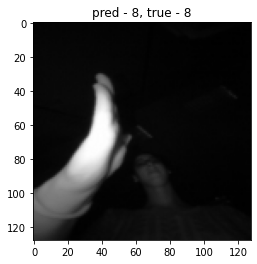

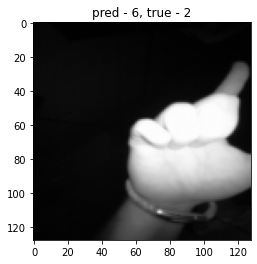

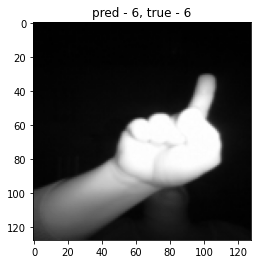

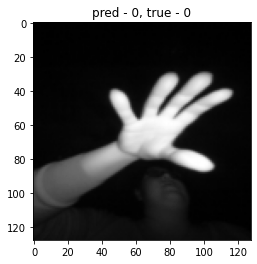

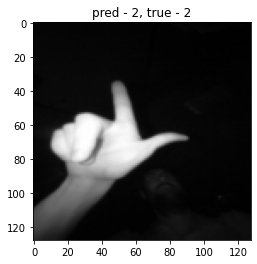

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_data_loader, 2):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = resnet152(images)
        plt.title(f'pred - {outputs[0].argmax()}, true - {labels[0]}')
        plt.imshow(images[0][0].cpu(), cmap='gray')
        plt.show()
        if i>5:
            break

In [ ]:
# сохраним модель
torch.save(resnet152, '/content/drive/MyDrive/Colab Notebooks/PyTorch/gestures_detection_model_resnet152_V2.pth')

In [ ]:
saved_model = torch.load('/content/drive/MyDrive/Colab Notebooks/PyTorch/gestures_detection_model_resnet152_V2.pth')
saved_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

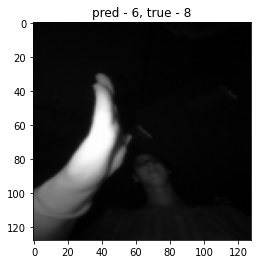

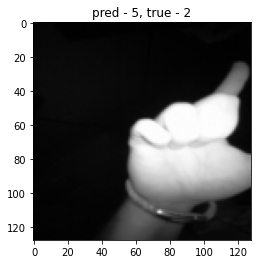

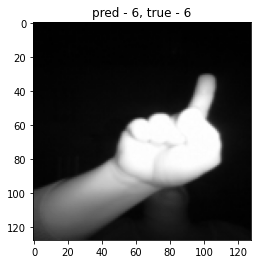

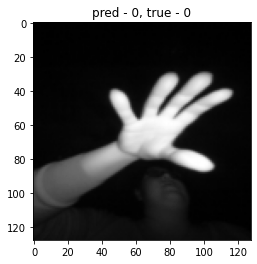

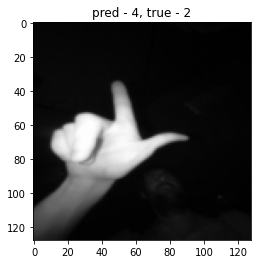

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_data_loader, 2):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = saved_model(images)
        plt.title(f'pred - {outputs[0].argmax()}, true - {labels[0]}')
        plt.imshow(images[0][0].cpu(), cmap='gray')
        plt.show()
        if i>5:
            break

Точность модели resnet152 немного выше, но 9 эпох также много для обучения. Огромным плюсов является, что модель обучается в разы быстрее чем написаннаю вручную (1 час против 15 мин).

## **HUMAN AND GESTURES DETECTOR**

### **IMAGE RECOGNITION**

In [ ]:
# модель распознования лиц
mtcnn = MTCNN()
# модель распознования жестов
saved_model = torch.load('/content/drive/MyDrive/Colab Notebooks/PyTorch/gestures_detection_model_resnet152.pth')
# saved_model = torch.load('/content/drive/MyDrive/Colab Notebooks/PyTorch/gestures_detection_model_resnet152_V2.pth')
# saved_model = torch.load('/content/drive/MyDrive/Colab Notebooks/PyTorch/gestures_detection_model_V2.pth')

In [ ]:
# напишем класс для детекции лица человека и его жестов

class FaceGestureDetector(object):
    """
    Face and gestures detector class
    """

    def __init__(self, mtcnn, model):

        self.mtcnn = mtcnn

        self.mp_hands = mp.solutions.hands
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_drawing_styles = mp.solutions.drawing_styles

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.gestures = model
        self.gestures.eval()


    def _draw(self, frame, boxes=None, probs=None, landmarks=None, hand_bboxes=None, hand_gestures=None, hand_lms=None):
        
        """
        Draw landmarks and boxes for each face and gesture detected
        """
        try:
            for box, prob, ld  in zip(boxes, probs, landmarks):  
                         

                # Draw rectangles on frame
                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)

                # Show probabilities
                cv2.putText(frame, 'Face', (box[0]+5, box[1]+25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Draw face landmarks
                cv2.circle(frame, tuple(ld[0]), 3, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 3, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 3, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 3, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 3, (0, 0, 255), -1)
                

        except:             
            pass

        try:        
            for hbox, gest, hld in zip(hand_bboxes, hand_gestures, hand_lms):
                # print(gest, gest2)

                # Draw rectangles on frame
                
                cv2.rectangle(frame, (hbox[0], hbox[1]), (hbox[2], hbox[3]), (255, 0, 255), 2)

                # Show probabilities
                cv2.putText(frame, gest, (hbox[0]+5, hbox[1]+25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2, cv2.LINE_AA)

                # Draw face landmarks
                self.mp_drawing.draw_landmarks(frame, hld, self.mp_hands.HAND_CONNECTIONS)  
                # return cv2_imshow(frame) 
        
        except:             
            pass
        
        return cv2_imshow(frame)    


    def get_hand_bbox(self, hand_landmarks, image_width, image_hight):
        """
        Calculate boxes for hand detected
        """
        x_max = 0
        y_max = 0
        x_min = image_width
        y_min = image_hight
        for lm in hand_landmarks.landmark:
            x, y = int(lm.x * image_width), int(lm.y * image_hight)
            if x > x_max:
                x_max = x + 20
            if x < x_min:
                x_min = x - 20
            if y > y_max:
                y_max = y + 20
            if y < y_min:
                y_min = y - 20
        return x_min, y_min, x_max, y_max


    def hand_detection(self, frame, boxes, probs, landmarks):
        """
        Detection hand two or one
        """
        with self.mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.7) as hands:

            # Convert the BGR image to RGB
            results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            hand_class = results.multi_handedness
            

            if not results.multi_hand_landmarks:
              cv2.putText(frame, 'I cannot detect hands. Sorry T_T', (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA) 
              self._draw(frame, boxes, probs, landmarks)
              # cv2_imshow(frame)
              bboxes = None
              return bboxes, hand_class, results.multi_hand_landmarks

            # Draw hand landmarks of each hand.
            image_hight, image_width, _ = frame.shape
            count_hands = len(results.multi_hand_landmarks)
            if count_hands == 1:
                for hand_landmarks in results.multi_hand_landmarks:                     
                    bboxes = [self.get_hand_bbox(hand_landmarks, image_width, image_hight)]
                return bboxes, hand_class, results.multi_hand_landmarks
            else:
                two_hands_bboxes = []
                for hand_landmarks in results.multi_hand_landmarks:                        
                      two_hands_bboxes.append(self.get_hand_bbox(hand_landmarks, image_width, image_hight))
                
                return two_hands_bboxes, hand_class, results.multi_hand_landmarks


    @staticmethod
    def crop_hands(frame, boxes):
        """
        Crop image for hands
        """
        num_hands = len(boxes)
        hands = []
        if num_hands == 2:
            for i, box in enumerate(boxes):
              hands.append(frame[box[1]:box[3], box[0]:box[2]])
            # cv2_imshow(hands[0])
            # cv2_imshow(hands[1])
            return hands
        for i, box in enumerate(boxes):
            hands.append(frame[box[1]:box[3], box[0]:box[2]])
            # cv2_imshow(hands[0])
        return hands


    @staticmethod
    def digit_to_classname(digit):
        if digit == 1:
            return '1_palm'
        elif digit == 2:
            return '2_handgun'
        elif digit == 3:
            return '3_wrist'
        elif digit == 4:
            return '4_rotated wrist'
        elif digit == 5:
            return '5_thumb'
        elif digit == 6:
            return '6_forefinger'
        elif digit == 7:
            return '7_okay'
        elif digit == 8:
            return '8_rotated palm'
        elif digit == 9:
            return '9_corner palm'
        elif digit == 0:
            return '10_outstretched palm'


    def hand_classification(self, hand):
        """
        Classification for each hand
        """
        hand = cv2.resize(hand, (128, 128))
        hand = cv2.cvtColor(hand, cv2.COLOR_BGR2GRAY)        
        hand = cv2.bitwise_not(hand)
        # hand = cv2.convertScaleAbs(hand, alpha=2.5, beta=20)
        # hand = cv2.convertScaleAbs(hand)
        cv2_imshow(hand)  
        hand = cv2.merge([hand, hand, hand])
        torch_hand = torch.from_numpy(hand).unsqueeze(0).to(self.device).float()
        gesture = self.gestures(torch_hand.permute(0, 3, 1, 2))
        # print(gesture[0].argmax())
        gesture = self.digit_to_classname(gesture[0].argmax())
        return gesture
                

    def run(self, path_to_img):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """                
        frame = cv2.imread(path_to_img)     
        # cv2_imshow(frame)     
        
        # Detect face box, probability and landmarks
        boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
        
        try:
            boxes = boxes.astype(int)        
            landmarks = landmarks.astype(int) 
                      
            
        except:
            cv2.putText(frame, 'I cannot detect human face. Sorry T_T', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)
            pass
        
       
        # Detect hand box, probability and landmarks
        hand_bboxes, hand_classes, hand_lm = self.hand_detection(frame, boxes, probs, landmarks)        
        
       
        # Crop hands
        if not hand_bboxes == None:
            hands = self.crop_hands(frame, hand_bboxes)
            
            # Hand classification   
            hand_gestures = []  
            if len(hands) == 2:
                for hand in hands: 
                    hand_gestures.append(self.hand_classification(hand))
            
            if len(hands) == 1:
                for hand in hands:                  
                        hand_gestures.append(self.hand_classification(hand))
    
            # Draw on frame
            self._draw(frame, boxes, probs, landmarks, hand_bboxes, hand_gestures, hand_lm)
            
        # Show the frame
        cv2.imwrite('Face_Hand_Detection.png', frame)

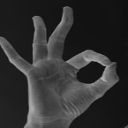

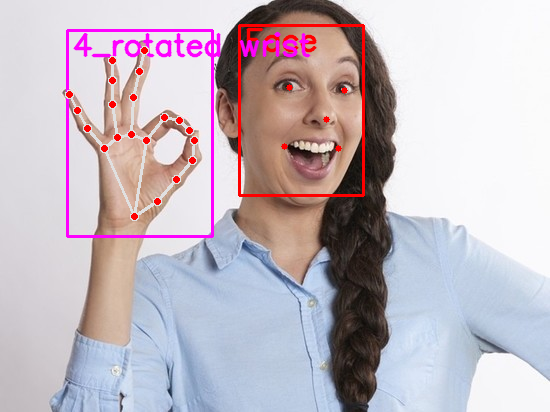

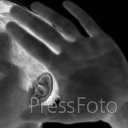

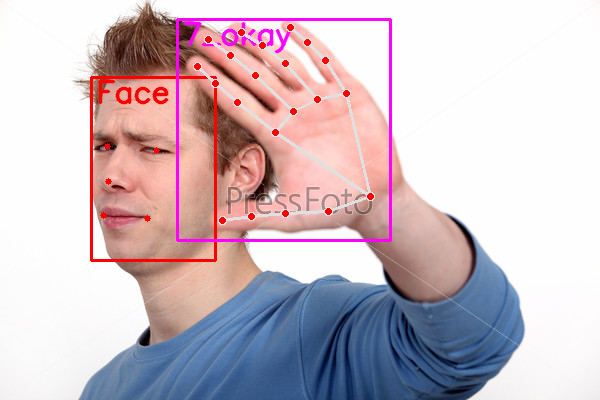

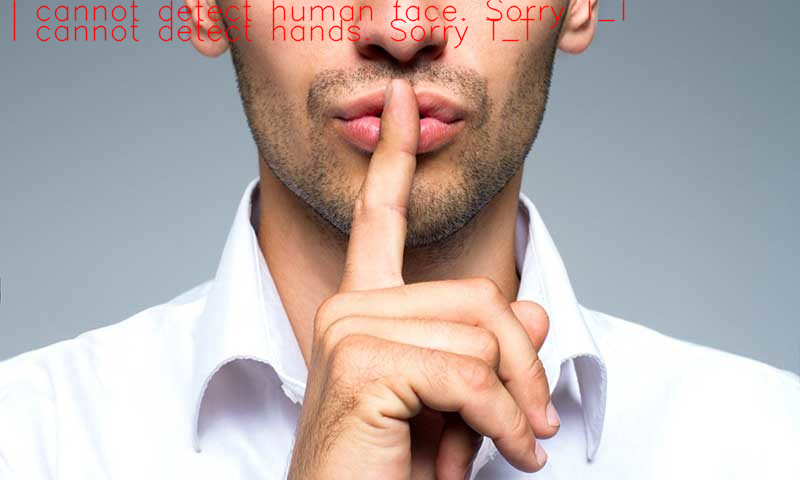

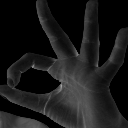

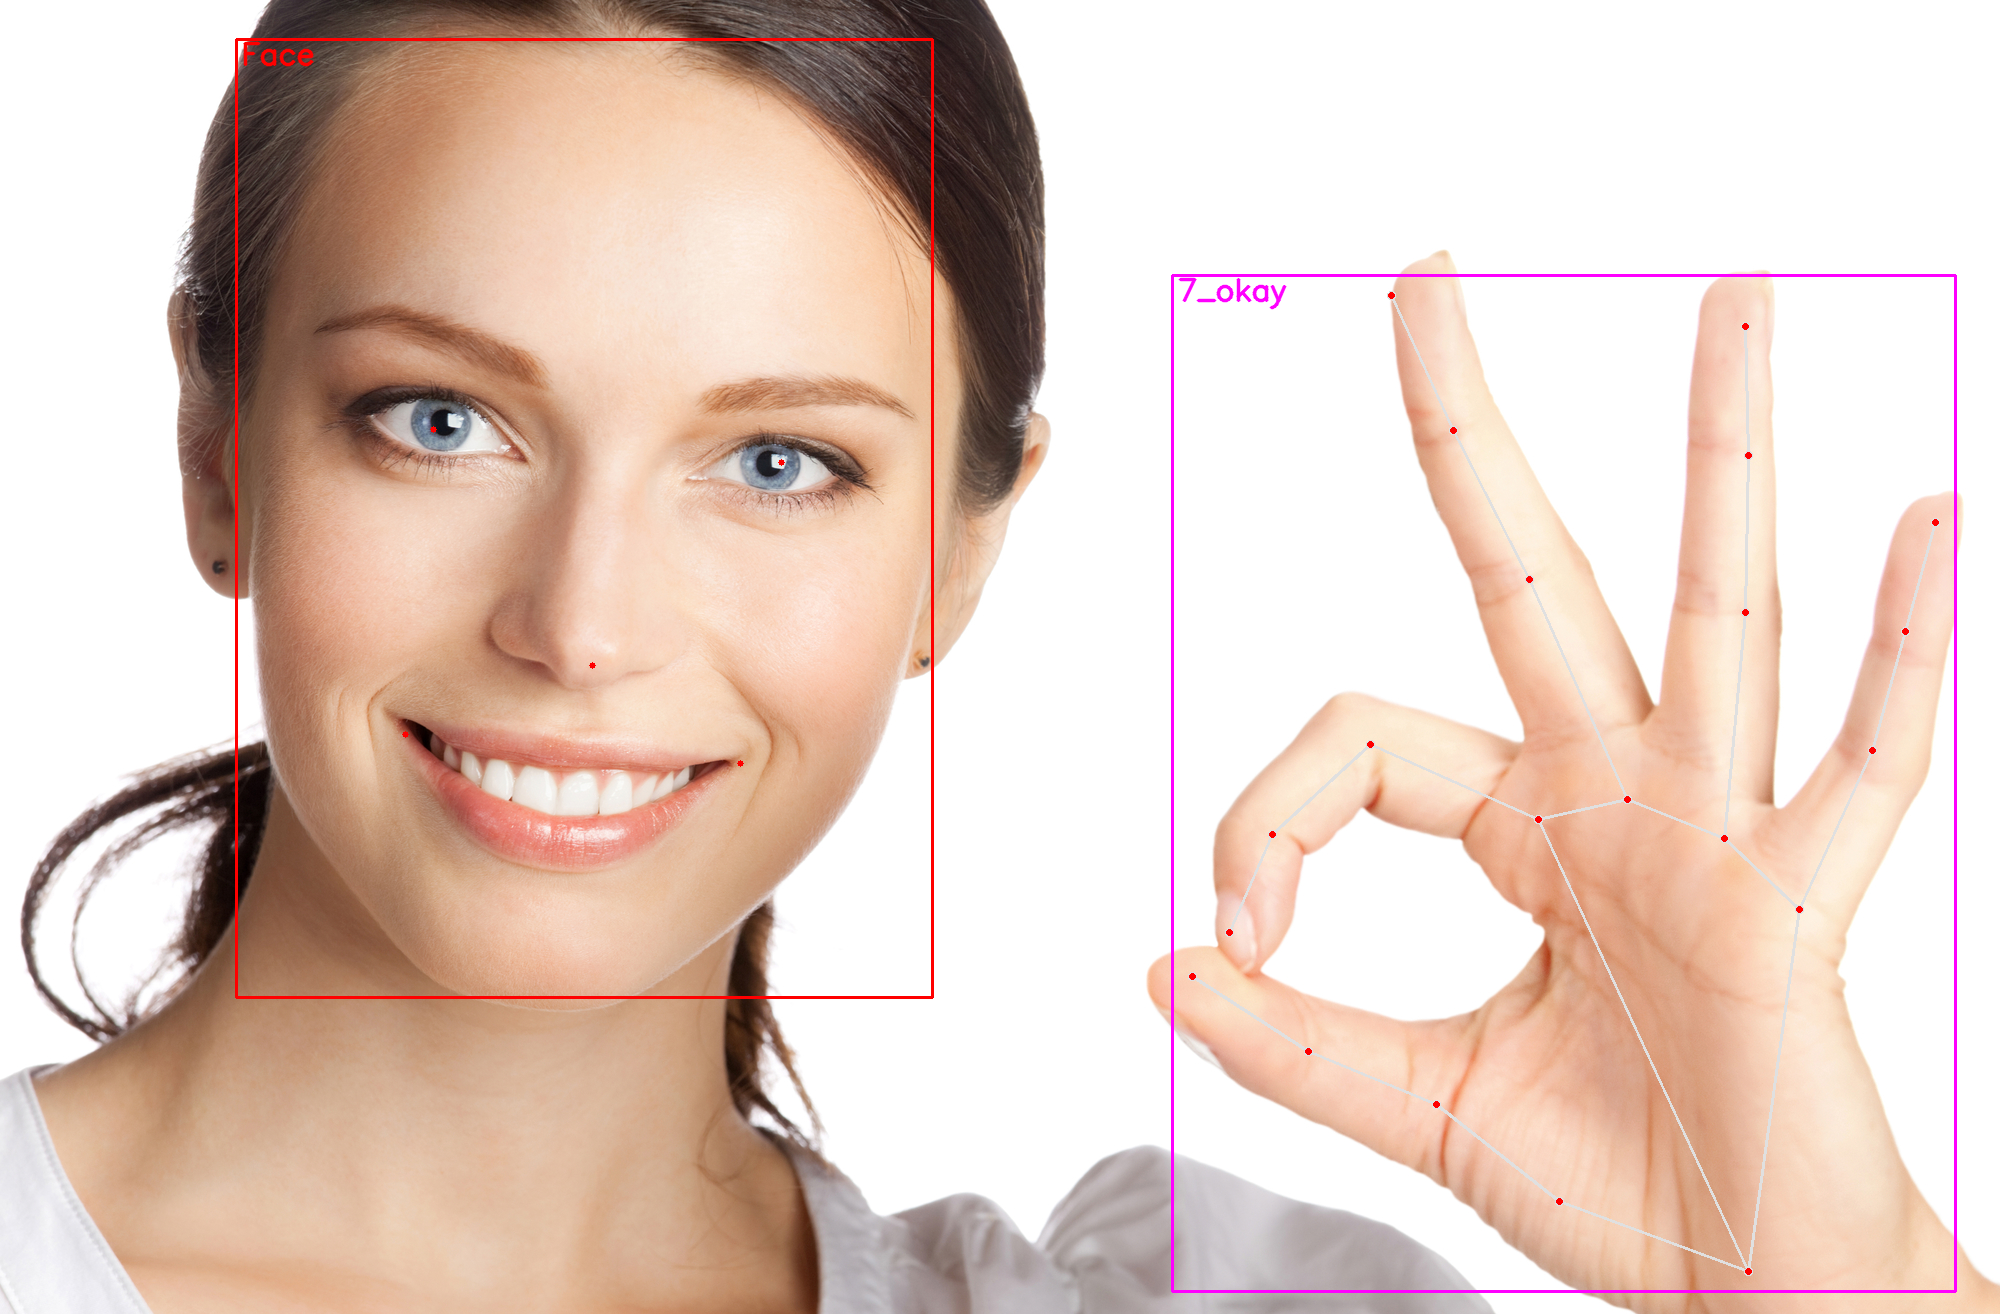

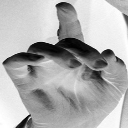

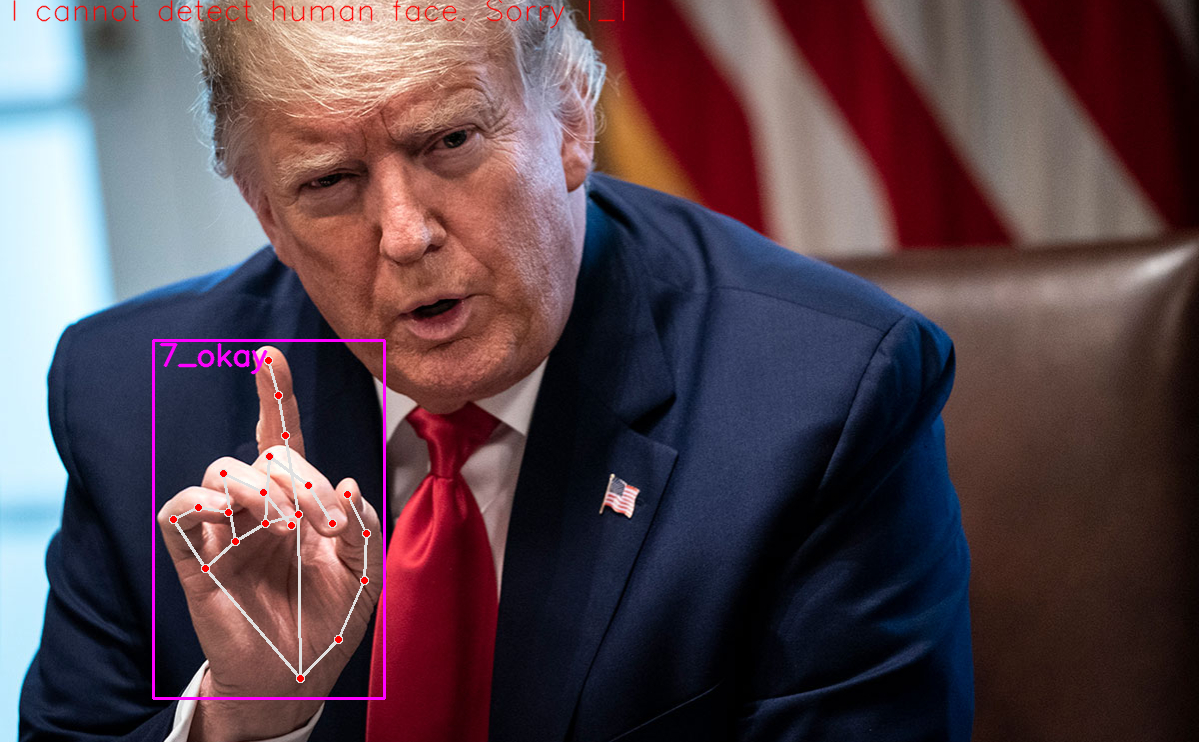

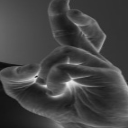

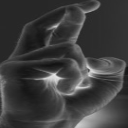

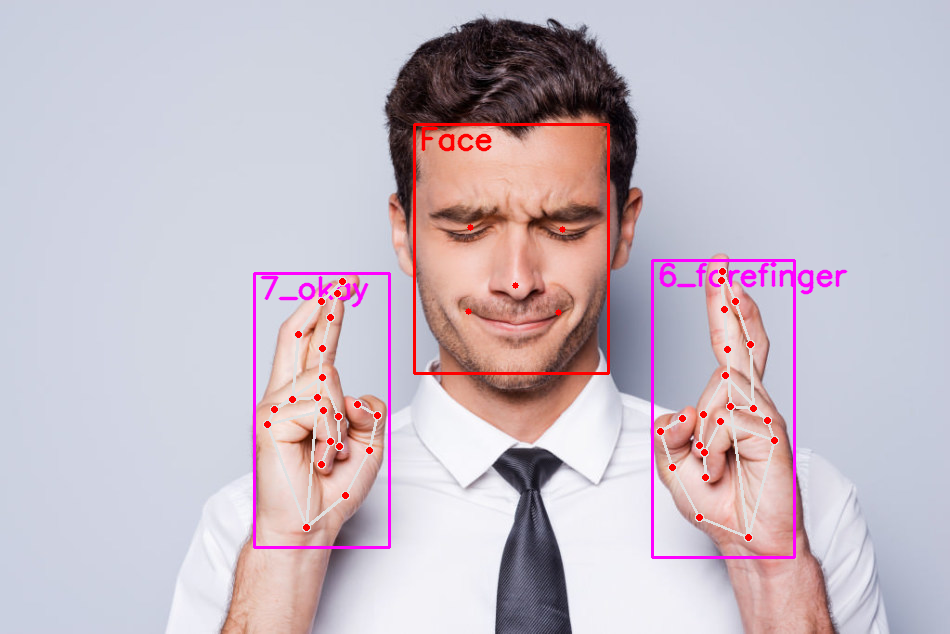

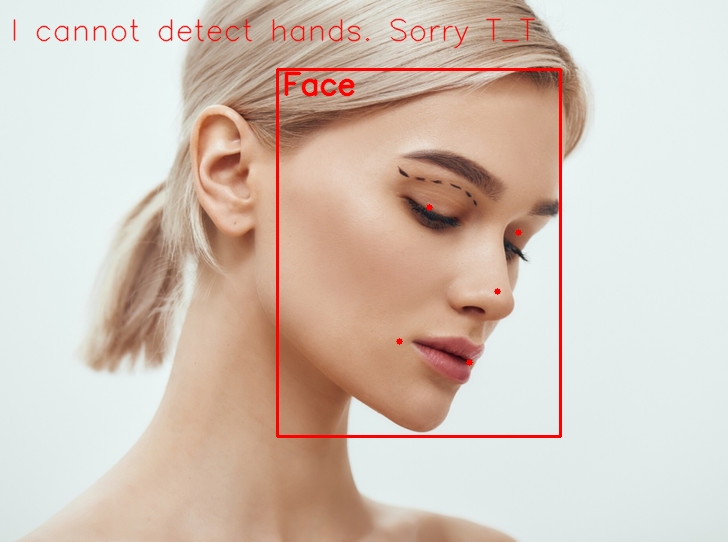

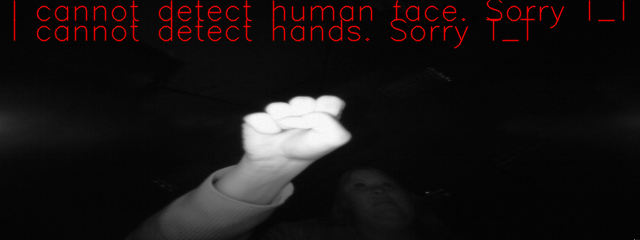

In [ ]:
# запустим скрипт на разных примерах картинок

fcd = FaceGestureDetector(mtcnn, saved_model)
fcd.run('/content/drive/MyDrive/Colab Notebooks/PyTorch/623954c36e9f1d71e89fc977f7f21dad.jpg')
fcd.run('/content/drive/MyDrive/Colab Notebooks/PyTorch/284587834290bdd8f5f3f16a0a6f270c5b794bdf968d_b.jpg')
fcd.run('/content/drive/MyDrive/Colab Notebooks/PyTorch/yazyk-zhestov-psihologiya-min-800x480.jpg')
fcd.run('/content/drive/MyDrive/Colab Notebooks/PyTorch/1638245102_2-na-dache-pro-p-devushka-ok-foto-2.jpg')
fcd.run('/content/drive/MyDrive/Colab Notebooks/PyTorch/756105669643188.jpg')
fcd.run('/content/drive/MyDrive/Colab Notebooks/PyTorch/skreshivaem.jpeg')
fcd.run('/content/drive/MyDrive/Colab Notebooks/PyTorch/728x542_1_be7d691076bf6806ba198515c5a84296@1200x894_0xac120003_20896392601639943602.jpeg')
fcd.run('/content/leapGestRecog/02/03_fist/frame_02_03_0002.png')

### **VIDEO CAPTURE RECOGNITION**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
# функция запуска камеры, фиксирования и распознования 5 шт. фото

def vc_hand_recognition(name):
        try:
          filename = take_photo(filename=name)
          print('Saved to {}'.format(filename))   
          # Show the image which was just taken.
          # display(Image(filename))
        except Exception as err:
          # Errors will be thrown if the user does not have a webcam or if they do not
          # grant the page permission to access it.
          print(str(err))
        
        mtcnn = MTCNN()
        # hand_model = torch.load('/content/drive/MyDrive/Colab Notebooks/PyTorch/gestures_detection_model_resnet152_V2.pth')
        hand_model = torch.load('/content/drive/MyDrive/Colab Notebooks/PyTorch/gestures_detection_model_resnet152.pth')
        fcd = FaceGestureDetector(mtcnn, hand_model)
        fcd.run(name)

<IPython.core.display.Javascript object>

Saved to 1.jpg


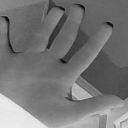

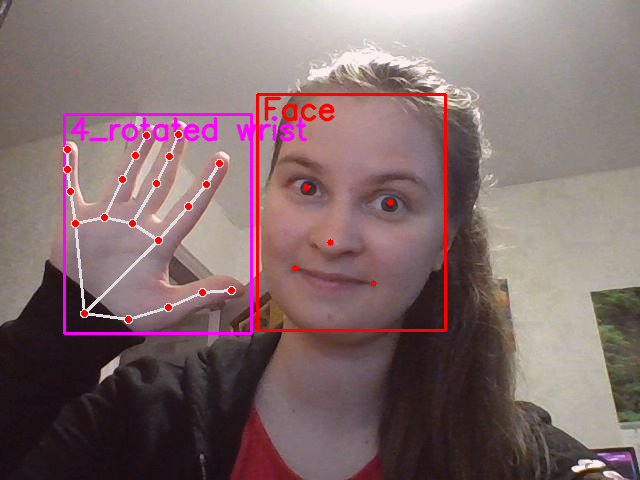

In [ ]:
# запустим функцию
vc_hand_recognition('1.jpg')

<IPython.core.display.Javascript object>

Saved to 2.jpg


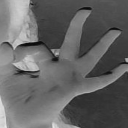

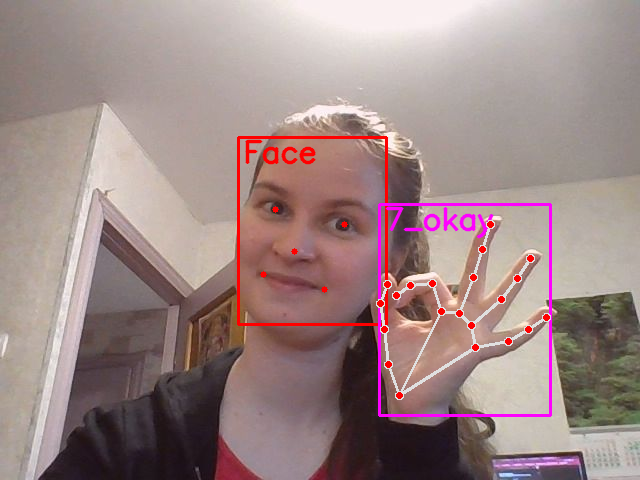

In [ ]:
# запустим функцию
vc_hand_recognition('2.jpg')

<IPython.core.display.Javascript object>

Saved to 3.jpg


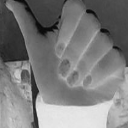

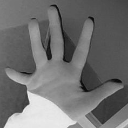

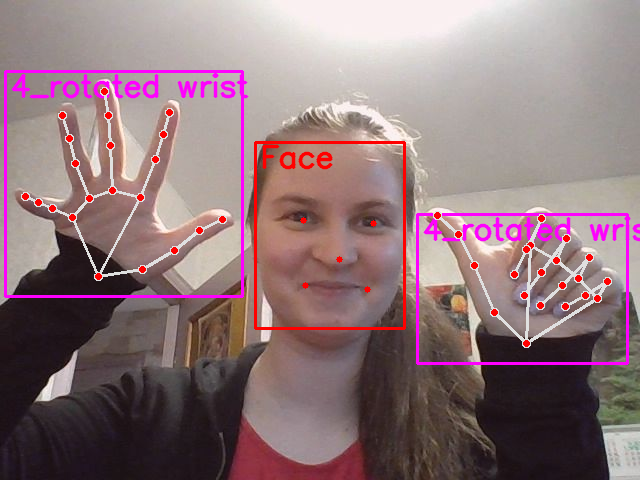

In [ ]:
# запустим функцию
vc_hand_recognition('3.jpg')

<IPython.core.display.Javascript object>

Saved to 4.jpg


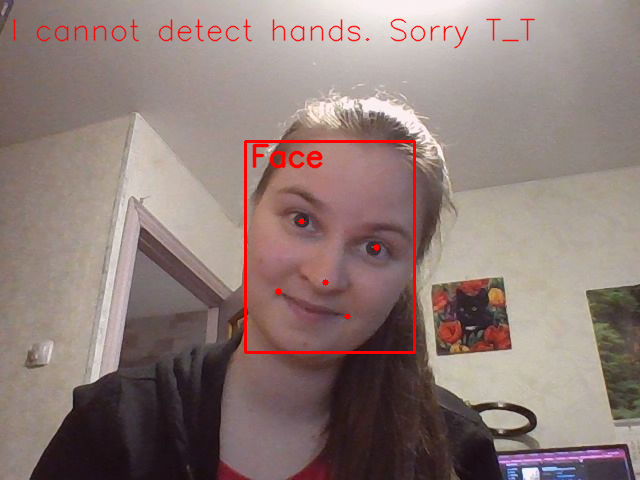

In [ ]:
# запустим функцию
vc_hand_recognition('4.jpg')

### **VIDEO STREAM RECOGNITION**

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# немного перепишем наш класс для детекции лица человека и его жестов

class VideoFaceGestureDetector(object):
    """
    Face and gestures detector class
    """

    def __init__(self, mtcnn, model):

        self.mtcnn = mtcnn

        self.mp_hands = mp.solutions.hands
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_drawing_styles = mp.solutions.drawing_styles

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.gestures = model
        self.gestures.eval()

    def _draw(self, frame, boxes, probs, landmarks, hand_bboxes, hand_gestures, hand_lms):
        
        """
        Draw landmarks and boxes for each face and gesture detected
        """
        try:
            for box, prob, ld  in zip(boxes, probs, landmarks):
                # Draw rectangles on frame
                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
                # Show probabilities
                cv2.putText(frame, 'Face', (box[0]+5, box[1]+25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                # Draw face landmarks
                cv2.circle(frame, tuple(ld[0]), 3, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 3, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 3, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 3, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 3, (0, 0, 255), -1)                        
        except:
            pass
        
        
        try:        
            for hbox, gest, hld in zip(hand_bboxes, hand_gestures, hand_lms):

                # Draw rectangles on frame
                cv2.putText(frame, 'I cannot detect human face. Sorry T_T', (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                cv2.rectangle(frame, (hbox[0], hbox[1]), (hbox[2], hbox[3]), (255, 0, 255), 2)

                # Show probabilities
                cv2.putText(frame, gest, (hbox[0]+5, hbox[1]+25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2, cv2.LINE_AA)

                # Draw face landmarks
                self.mp_drawing.draw_landmarks(frame, hld, self.mp_hands.HAND_CONNECTIONS)  

             
        
        except:  
            pass
        
        # return cv2_imshow(frame)  


    def get_hand_bbox(self, hand_landmarks, image_width, image_hight):
        x_max = 0
        y_max = 0
        x_min = image_width
        y_min = image_hight
        for lm in hand_landmarks.landmark:
            x, y = int(lm.x * image_width), int(lm.y * image_hight)
            if x > x_max:
                x_max = x + 20
            if x < x_min:
                x_min = x - 20
            if y > y_max:
                y_max = y + 20
            if y < y_min:
                y_min = y - 20
        return x_min, y_min, x_max, y_max


    def hand_detection(self, frame):
        with self.mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.7) as hands:

            # Convert the BGR image to RGB
            results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            hand_class = results.multi_handedness

            if not results.multi_hand_landmarks:
              # print(f'No hands in the frame')
              # cv2_imshow(frame)
              bboxes = None
              return bboxes, hand_class, results.multi_hand_landmarks

            # Draw hand landmarks of each hand.
            image_hight, image_width, _ = frame.shape
            count_hands = len(results.multi_hand_landmarks)
            if count_hands == 1:
                for hand_landmarks in results.multi_hand_landmarks:                     
                    bboxes = [self.get_hand_bbox(hand_landmarks, image_width, image_hight)]
                return bboxes, hand_class, results.multi_hand_landmarks
            else:
                two_hands_bboxes = []
                for hand_landmarks in results.multi_hand_landmarks:                        
                      two_hands_bboxes.append(self.get_hand_bbox(hand_landmarks, image_width, image_hight))
                return two_hands_bboxes, hand_class, results.multi_hand_landmarks


    @staticmethod
    def crop_hands(frame, boxes):
        """
        Crop image for hands
        """
        num_hands = len(boxes)
        hands = []
        if num_hands == 2:
            for i, box in enumerate(boxes):
                hands.append(frame[box[1]:box[3], box[0]:box[2]])
                # cv2_imshow(hands[0])
                # cv2_imshow(hands[1])
            return hands
        for i, box in enumerate(boxes):
            hands.append(frame[box[1]:box[3], box[0]:box[2]])
            # cv2_imshow(hands[0])
        return hands


    @staticmethod
    def digit_to_classname(digit):
        """
        Convert digit class names to text
        """
        class_names_ru = ['palm', 'handgun', 'wrist', 'rotated wrist', 'thumb', 'forefinger', 'okay', 'rotated palm', 'corner palm', 'outstretched palm']
        for item in range(len(class_names_ru)):
            if digit == item:
                return class_names_ru[digit]

    def hand_classification(self, hand):
        hand = cv2.resize(hand, (128, 128))
        hand = cv2.cvtColor(hand, cv2.COLOR_BGR2GRAY)
        hand = cv2.bitwise_not(hand)
        hand = cv2.convertScaleAbs(hand, alpha=2.5, beta=90)
        hand = cv2.merge([hand, hand, hand])
        torch_hand = torch.from_numpy(hand).unsqueeze(0).to(self.device).float()
        gesture = self.gestures(torch_hand.permute(0, 3, 1, 2))
        gesture = self.digit_to_classname(gesture.argmax())

        return gesture
                
    @staticmethod
    def get_face_bbox(frame):
        boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)
        boxes = boxes.astype(int)
        landmarks = landmarks.astype(int)
        return boxes, probs, landmarks
    
    
    def run(self, frame):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """                
        # frame = cv2.imread(path_to_img)     
        # cv2_imshow(frame)     
        
        # Detect face box, probability and landmarks
        boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)

        try:
            boxes = boxes.astype(int)        
            landmarks = landmarks.astype(int) 
            return boxes, probs, landmarks
            
        except:
            pass
        
       
        # Detect hand box, probability and landmarks
        hand_bboxes, hand_classes, hand_lm = self.hand_detection(frame)
        
        try:
            # Crop hands
            if not hand_bboxes == None:
                hands = self.crop_hands(frame, hand_bboxes)
                
                # Hand classification   
                hand_gestures = []  
                if len(hands) == 2:
                    for hand in hands: 
                        hand_gestures.append(self.hand_classification(hand))
                if len(hands) == 1:
                    for hand in hands:                  
                            hand_gestures.append(self.hand_classification(hand))
            
            return boxes, probs, landmarks, hand_bboxes, hand_gestures, hand_lm    

        except:
            pass
        
        
        
        # Draw on frame
        # self._draw(frame, boxes, probs, landmarks, hand_bboxes, hand_gestures, hand_lm)
        
        # Show the frame
        # cv2.imwrite('Face_Hand_Detection.png', frame)


In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing face or hand'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    hand_array = np.zeros([480,640,4], dtype=np.uint8)

    mtcnn = MTCNN()
    hand_model = torch.load('/content/drive/MyDrive/Colab Notebooks/PyTorch/gestures_detection_model_resnet152.pth')
    fgd = VideoFaceGestureDetector(mtcnn, hand_model)

    try:
      faces = fgd.run(img)[0]
      print(f'Face {faces}')
    except:
      pass

    try:
      # get face bounding box for overlay
      for (x, y , w, h) in faces:
        bbox_array = cv2.rectangle(bbox_array,(x,y),(w,h),(255,0,0),2)    
      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

      # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
      
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes
    except:
      pass

    try:
      hand = fgd.run(img)[3]
      print(f'Hand {hand}')
    except:
      pass

    try:
      # get hand bounding box for overlay
      for (x, y , w, h) in hand:
        hand_array = cv2.rectangle(hand_array,(x,y),(w,h),(255,0,0),2)      
      hand_array[:,:,3] = (hand_array.max(axis = 2) > 0 ).astype(int) * 255
      hand_bbox_bytes = bbox_to_bytes(hand_array)
      bbox = hand_bbox_bytes
    except:
      pass


# Face [[299  56 492 305]]
# Face [[307  61 489 289]]
# Face [[331  75 506 290]]
# Face None
# Hand [(141, 84, 301, 350)]
# Face None
# Hand [(80, 81, 224, 342)]
# Face None
# Hand [(55, 108, 186, 355)]
# Face None
# Hand [(160, 102, 303, 360)]
# Face [[345  15 533 246]]
# Face [[334 -19 527 210]]

## **ВЫВОД**

В ходе курсовой работы: 
* был создан классификатор для распознования жестов, 
* написан скрипт для детекции лица человека и его рук 
* с последующей классификацией жестов.

Для классификатора жестов был взят датасет **leapgestrecog** из 20 000 примеров. Обучение прошло успешно, однако для реального применения датасет оказался довольно плох, так как исходные картинки несопоставимы по качеству, цвету и форме с реальными кадрами с камеры. В связи с чем классификация на кадрах с камеры работает с переменным успехом. Стоит попробовать другие датасеты для обучения. Для распознавания была попытка использовать инверсию цвета кадра, и даже руки в перчатках, но все равно классификация проходит плохо.

Как уже упоминалось выше, обучение самописной модели классификатора происходило в несколько раз медленнее, чем предобученной модели, такой как **resnet152**. Для последующего использования была взята именно resnet152. Для повышения точности, модель была переобучена на меньшем количестве эпох. При экспериментах с камерой, оказалось, что модель на меньшем количестве эпох все-таки работает хуже.

Для детектора лиц была использована модель **mtcnn**, для детекции рук - **mediapipe**. Удалось отрисовать рамки лица и рук, а также присоединить классификатор жестов. 

Рассмотрены случаи, когда в кадре:
* только одна рука, 
* когда 2 руки,  
* рук нет вообще.

Детектор был испробован, как на различных картинках из Интернета, так и на кадрах с видеокамеры.

Также была попытка присоединить детектер к видеопотоку. На данный момент удалось только вывести рамки для лица и рук по отдельности. Определнно не хватает знаний по языку **javascript** для решения подобных задач.


**Полезные ссылки:**

[Видеозахват с камеры в Colab](https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=buJCl90WhNfq)

[Computer Vision Crash Course](https://colab.research.google.com/drive/13YSigxuNyacOIxxXjiK6fZbZAA2MQZzy?usp=sharing#scrollTo=BUPmGFZFt2wm)

[Video Stream in Colab](https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw#scrollTo=1nkSnkbkk4cC)